<a href="https://colab.research.google.com/github/Pragadesh-45/Nivu-5-Day-Bootcamp-Notebooks/blob/main/cardiovascular_disease_classification_pred.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
!pip install optuna

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set_style('darkgrid')
import plotly.express as px
from plotly.offline import init_notebook_mode
init_notebook_mode(connected=True)
import cufflinks as cf
cf.go_offline()
cf.set_config_file(offline=False, world_readable=True)
import tensorflow as tf
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, recall_score
import optuna
import warnings
warnings.filterwarnings('ignore')

In [5]:
tf.test.gpu_device_name()

'/device:GPU:0'

# 1. EDA

## 1.x. Data Understanding

In [6]:
heart = pd.read_csv('cardio_train.csv', sep=';')
heart.head()

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,0,18393,2,168,62.0,110,80,1,1,0,0,1,0
1,1,20228,1,156,85.0,140,90,3,1,0,0,1,1
2,2,18857,1,165,64.0,130,70,3,1,0,0,0,1
3,3,17623,2,169,82.0,150,100,1,1,0,0,1,1
4,4,17474,1,156,56.0,100,60,1,1,0,0,0,0


In [7]:
heart.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70000 entries, 0 to 69999
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   id           70000 non-null  int64  
 1   age          70000 non-null  int64  
 2   gender       70000 non-null  int64  
 3   height       70000 non-null  int64  
 4   weight       70000 non-null  float64
 5   ap_hi        70000 non-null  int64  
 6   ap_lo        70000 non-null  int64  
 7   cholesterol  70000 non-null  int64  
 8   gluc         70000 non-null  int64  
 9   smoke        70000 non-null  int64  
 10  alco         70000 non-null  int64  
 11  active       70000 non-null  int64  
 12  cardio       70000 non-null  int64  
dtypes: float64(1), int64(12)
memory usage: 6.9 MB


In [8]:
heart.nunique()

id             70000
age             8076
gender             2
height           109
weight           287
ap_hi            153
ap_lo            157
cholesterol        3
gluc               3
smoke              2
alco               2
active             2
cardio             2
dtype: int64

## 1.xx. Data Manipulation

In [9]:
heart['age'] = (heart['age'] / 365).astype('int')

In [10]:
heart.drop('id', axis=1, inplace=True)

## 1.xxx. Correlation Analysis

In [11]:
hear_corr = heart.corr(numeric_only=True)
hear_corr

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
age,1.000000,-0.022913,-0.081506,0.053561,0.020854,0.017620,0.154012,0.098388,-0.047649,-0.029756,-0.009998,0.237985
gender,-0.022913,1.000000,0.499033,0.155406,0.006005,0.015254,-0.035821,-0.020491,0.338135,0.170966,0.005866,0.008109
height,-0.081506,0.499033,1.000000,0.290968,0.005488,0.006150,-0.050226,-0.018595,0.187989,0.094419,-0.006570,-0.010821
weight,0.053561,0.155406,0.290968,1.000000,0.030702,0.043710,0.141768,0.106857,0.067780,0.067113,-0.016867,0.181660
ap_hi,0.020854,0.006005,0.005488,0.030702,1.000000,0.016086,0.023778,0.011841,-0.000922,0.001408,-0.000033,0.054475
ap_lo,0.017620,0.015254,0.006150,0.043710,0.016086,1.000000,0.024019,0.010806,0.005186,0.010601,0.004780,0.065719
cholesterol,0.154012,-0.035821,-0.050226,0.141768,0.023778,0.024019,1.000000,0.451578,0.010354,0.035760,0.009911,0.221147
gluc,0.098388,-0.020491,-0.018595,0.106857,0.011841,0.010806,0.451578,1.000000,-0.004756,0.011246,-0.006770,0.089307
smoke,-0.047649,0.338135,0.187989,0.067780,-0.000922,0.005186,0.010354,-0.004756,1.000000,0.340094,0.025858,-0.015486
alco,-0.029756,0.170966,0.094419,0.067113,0.001408,0.010601,0.035760,0.011246,0.340094,1.000000,0.025476,-0.007330


## 1.xxxx. Data Visualization

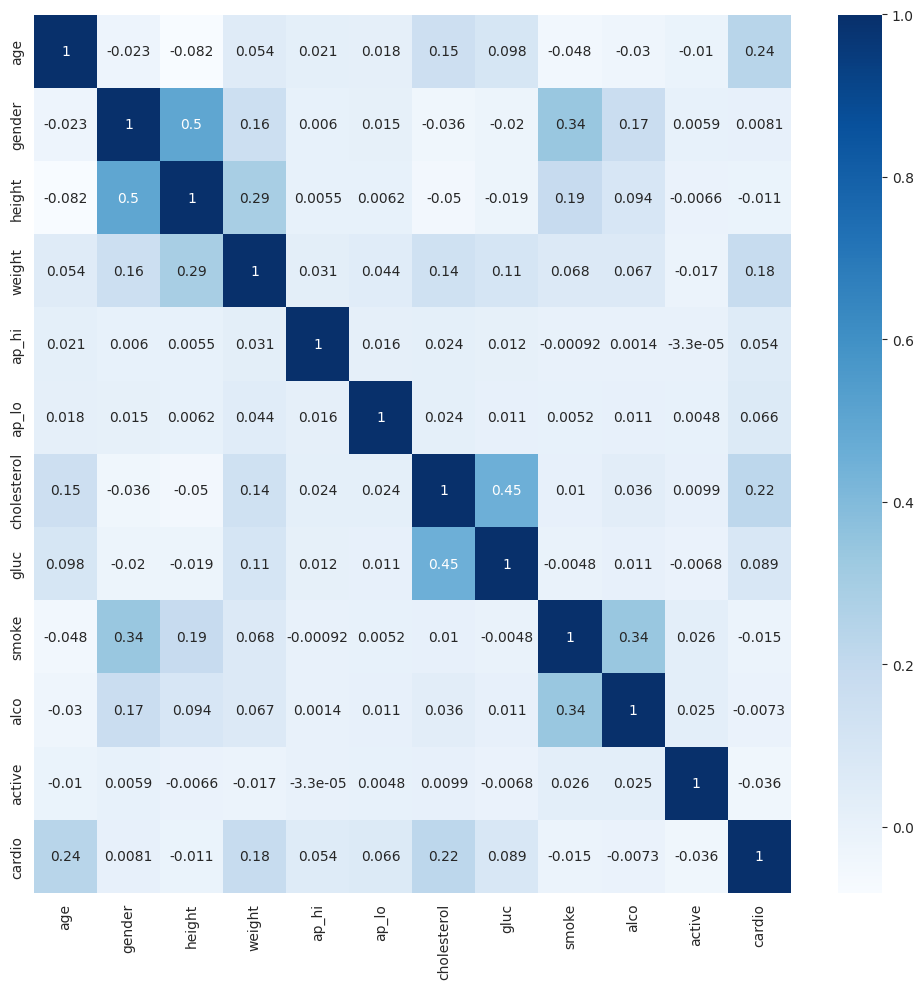

In [12]:
plt.figure(figsize=(10, 10))
sns.heatmap(hear_corr, annot=True, cmap='Blues')
plt.tight_layout()

In [13]:
age_cardio = pd.DataFrame({
    'The Cardiac disease by average' : heart.groupby('age')['cardio'].mean(numeric_only=True),
    'Age' : sorted(heart['age'].unique())
})
px.bar(age_cardio, 'Age', 'The Cardiac disease by average', color='Age',
       title='The risk of Cardiac disease by increasing Age')

In [14]:
age_chol = pd.DataFrame({
    'The Cardiac disease by average' : heart.groupby('cholesterol')['cardio'].mean(numeric_only=True),
    'The amount of Cholesterol' : ['Normal', 'Above Normal', 'Well Above Normal']
})
px.bar(age_chol, 'The amount of Cholesterol', 'The Cardiac disease by average',
       color='The amount of Cholesterol', title='The risk of Cardiac disease by increasing Cholesterol')

# 2. Data Preprocessing

In [15]:
X = heart.drop('cardio', axis=1)
y = heart['cardio']

In [16]:
np.unique(y, return_counts=True)

(array([0, 1]), array([35021, 34979]))

## 2.x. Data Transformation

In [17]:
y = pd.get_dummies(y) # OHE
y.head()

,0,1
0,1,0
1,0,1
2,0,1
3,0,1
4,1,0


In [18]:
ss = StandardScaler()
X = ss.fit_transform(X)

In [19]:
X

array([[-0.41980002,  1.36405487,  0.44345206, ..., -0.31087913,
        -0.23838436,  0.49416711],
       [ 0.31910983, -0.73310834, -1.01816804, ..., -0.31087913,
        -0.23838436,  0.49416711],
       [-0.27201805, -0.73310834,  0.07804703, ..., -0.31087913,
        -0.23838436, -2.02360695],
       ...,
       [-0.12423608,  1.36405487,  2.27047718, ..., -0.31087913,
         4.19490608, -2.02360695],
       [ 1.20580165, -0.73310834, -0.16555632, ..., -0.31087913,
        -0.23838436, -2.02360695],
       [ 0.4668918 , -0.73310834,  0.68705541, ..., -0.31087913,
        -0.23838436,  0.49416711]])

# 3. Data Modeling

In [20]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

In [21]:
neural_network = tf.keras.models.Sequential([
    # Input Layer
    tf.keras.layers.Dense(units=X_train.shape[1], activation='relu', input_shape=(11,)),
    # Hidden Layer
    tf.keras.layers.Dense(units=3390, activation='relu'),
    tf.keras.layers.Dropout(rate=0.6134244952254351),
    tf.keras.layers.Dense(units=1921, activation='relu'),
    tf.keras.layers.Dropout(0.8995971525795465),
    tf.keras.layers.Dense(units=696, activation='relu'),
    tf.keras.layers.Dropout(0.37728953141458194),
    tf.keras.layers.Dense(units=3203, activation='relu'),
    tf.keras.layers.Dropout(0.4140447715184241),
    tf.keras.layers.Dense(units=1191, activation='relu'),
    tf.keras.layers.Dropout(0.777425398521235),
    # Output Layer
    tf.keras.layers.Dense(units=2, activation='softmax')
])

neural_network.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
                       loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
                       metrics=tf.keras.metrics.CategoricalAccuracy())
print(neural_network.summary())

BATCH_SIZE = 256
ES = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
MC = tf.keras.callbacks.ModelCheckpoint('/kaggle/working/model_weights.h5', monitor='val_loss', save_best_only=True)
RLR = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=.2, patience=2)
STEPS_PER_EPOCHS = round(X_train.shape[0] / BATCH_SIZE)
history = neural_network.fit(
    X_train,
    y_train,
    steps_per_epoch=STEPS_PER_EPOCHS,
    epochs=20,
    validation_data=(X_test, y_test),
    batch_size=BATCH_SIZE,
    callbacks=[ES, MC, RLR]
)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 11)                132       
                                                                 
 dense_1 (Dense)             (None, 3390)              40680     
                                                                 
 dropout (Dropout)           (None, 3390)              0         
                                                                 
 dense_2 (Dense)             (None, 1921)              6514111   
                                                                 
 dropout_1 (Dropout)         (None, 1921)              0         
                                                                 
 dense_3 (Dense)             (None, 696)               1337712   
                                                                 
 dropout_2 (Dropout)         (None, 696)               0

# 4. Data Evaluation

## 4.x. Data Visualization

In [ ]:
plt.figure(figsize=(6, 6))
plt.plot(history.history['loss'], color='red', label='loss');
plt.plot(history.history['val_loss'], color='blue', label='val_loss');
plt.legend();
plt.tight_layout();

In [ ]:
plt.figure(figsize=(6, 6))
plt.plot(history.history['categorical_accuracy'], color='red', label='categorical_accuracy');
plt.plot(history.history['val_categorical_accuracy'], color='blue', label='val_categorical_accuracy');
plt.legend();
plt.tight_layout();

## 4.xx. Inference and Evaluation

In [ ]:
y_preds = neural_network.predict(X_test)

In [ ]:
y_preds

In [ ]:
pred_vals = []
for y_pred in y_preds:
    pred_vals.append(np.argmax(y_pred))

true_vals = []
for val in y_test.values:
    true_vals.append(np.argmax(val))

In [ ]:
print(classification_report(true_vals, pred_vals))

In [ ]:
print(confusion_matrix(true_vals, pred_vals))